# Skytrax Webscrapping Project

Hi everyone. The inspiration from this project came from a YouTube video I watched on a Tableau Portfolio Project (https://www.youtube.com/watch?v=KlAKAarfLRQ&ab_channel=MoChen). The project uses the reviews on British Airways from the website Skytrax. I found the dataset he used on Kaggle (https://www.kaggle.com/datasets/dharun4772/british-airline-review-dataset/data) but I wanted to try to code it out myself. I will then create my own review visualization tool on Tableau.


A bit of background on myself, I am making a transition into the data analytics/data science industry. This jupyter notebook will show my workflow on how I performed the webscrapping, starting from a extracting a single component of a review, to writing the individual for loops, combining all the loops together, and finally writing the code to make it possible to extract the reviews for any airline on Skytrax. Quick disclaimer, I am still fairly new to all of this so I appreciate any feedback. 

For this project, I started with a single airline that I fly a lot, Cathay Pacific. I started with a single page and changed the settings so that 100 reviews were displayed per page.
https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/1/?sortby=post_date%3ADesc&pagesize=100

In [1]:
# Import packages we will be using
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

The first and most important thing we need to do and check is successfully connect to the url and obtain the beautiful soup. Response [200] means we successfully connected. For this project, I set the website to have 100 reviews per page.

In [2]:
# Connecting to URL 
url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/1/?sortby=post_date%3ADesc&pagesize=100'
response = requests.get(url)
print(response)
soup = BeautifulSoup(response.text, 'html.parser')

<Response [200]>


We can now begin webscrapping. Here's an example of a what a review looks like. For this project, I thought it would be best to approach each component of the review one at a time. I split up the scrapping in the following way:

Overall Rating

Review Header

Reviewer Location

Review Date

Trip Verified

Review TextBody

Review StatsBody

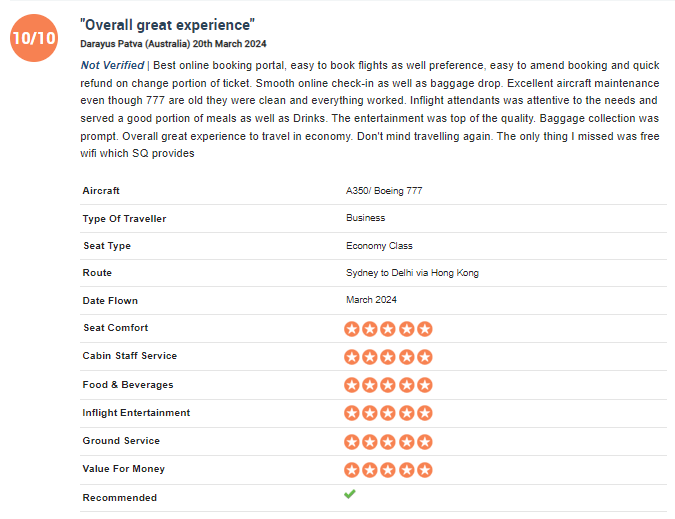

### Web scrapping a single page
The code block below is how I scrapped each component of the review. While each has their own special tuning, they follow the very standard procedure of filtering with the find_all function.

In [3]:
# Getting the overall ratings for each review on one page
overall_rating_df  = pd.DataFrame({})
rating_values = []
rating_divs = soup.find_all('div', {'itemprop': 'reviewRating'})
for div in rating_divs:
    span = div.find('span', itemprop='ratingValue')
    if span:
        rating_values.append(span.get_text())
    else:
        rating_values.append('na')
overall_rating_df = pd.DataFrame(rating_values, columns=['overall_rating'])

# Getting the review titles for one page
review_titles_df = pd.DataFrame({})
review_titles = soup.find_all('h2', {'class': 'text_header'})
review_titles = pd.Series([x.text.strip() for x in review_titles])
review_titles = review_titles.iloc[:-4]
review_titles_df = pd.concat([review_titles_df,review_titles], ignore_index=True)

# Getting the reviewer location
reviewer_location_df = pd.DataFrame({})
reviewer_location = soup.find_all('h3', {'class': 'text_sub_header userStatusWrapper'})
pattern = re.compile(r'\((.*?)\)') # use a pattern recognizer to only pull strings within parentheses
reviewer_location = pd.Series([pattern.search(str(elem)).group(1) if pattern.search(str(elem)) else None for elem in reviewer_location])# list comprehension with the pattern recognizer
reviewer_location_df = pd.concat([reviewer_location_df,reviewer_location], ignore_index=True)

# Getting the review date
review_date_df = pd.DataFrame({})
review_date = soup.find_all('time', {'datetime': re.compile(r'.*')})
review_date = pd.Series([x.text.strip() for x in review_date])
review_date_df = pd.concat([review_date_df,review_date], ignore_index=True)

# Getting the trip verified for one page
trip_verified_df = pd.DataFrame({})
trip_verified = soup.find_all('div', {'class': 'text_content'})
trip_verified = pd.Series([verification.find('em').get_text() if verification.find('em') else 'Not Verified' for verification in trip_verified ])
trip_verified_df = pd.concat([trip_verified_df,trip_verified], ignore_index=True)

# Getting the text body for one page
text_body_df = pd.DataFrame({})
text_body = soup.find_all('div', {'class': 'text_content', 'itemprop': 'reviewBody'})
text_body = pd.Series([x.text.strip() for x in text_body])
text_body = text_body.apply(lambda x: x.split('|')[-1].strip() if '|' in x else x)
text_body_df = pd.concat([text_body_df,text_body], ignore_index=True)

# Getting all the review headers and values for each review for one page
review_body_df = pd.DataFrame({})
review_body = []
review_values_containers = soup.find_all('div', {'class': 'tc_mobile'})
for review_value in review_values_containers:
  # Extract review stats table from the current review value container
  review_stats_table = review_value.find('table', class_='review-ratings')
   
  if review_stats_table:
    # Extract rows from the table
    rows = review_stats_table.find_all('tr')
     
    # Extract data from rows
    review_ratings = {}
    for row in rows:
      header_elem = row.find(class_='review-rating-header')
      if header_elem:
        header = header_elem.get_text(strip=True)
         
        # Check if review-value class exists
        value_elem = row.find(class_='review-value')
        if value_elem:
          value = value_elem.get_text(strip=True)
        else:
            star_fill_elements = row.select('.review-rating-stars .star.fill')
            value = len(star_fill_elements) # Set a default value if review-value is not found
         
        review_ratings[header] = value
     
    # Append the extracted data for the current review to the list
    review_body.append(review_ratings)
    review_body_temp_df = pd.DataFrame(review_body)
    review_body_df = pd.concat([review_body_df, review_body_temp_df], ignore_index=True)

### Getting the number of review pages
Once I figured out how to get the review information from one page, I created a function to get the total number of pages we need to go through to get all of the reviews.

In [4]:
# Function to get the number of reivew pages for the airline
def pagenumbers(soup):
    # Getting the total number of pages we need to scrape through
    num_pages = soup.find_all(['url','li','a'])
    num_pages = [x.text.strip() for x in num_pages]
    # The page numbers are inbetween the double angle brackets so we can filter out with them
    start_page = num_pages.index('<<') 
    end_page = num_pages.index('>>')
    result_pages = int(num_pages[start_page+1:end_page][-1])
    return result_pages

In [5]:
# Getting the number of webpages
url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/1/?sortby=post_date%3ADesc&pagesize=100'
response = requests.get(url)
print(response)
soup = BeautifulSoup(response.text, 'html.parser')
result_pages = pagenumbers(soup)
print(result_pages)

<Response [200]>
15


### Looping through all the webpages for one airline

We can now get the reviews from all of the webpages.

In [6]:
# Loop through all the airline review pages
overall_rating_df = pd.DataFrame({})
rating_values = []
# overall rating for loop
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    rating_divs = soup.find_all('div', {'itemprop': 'reviewRating'})
    for div in rating_divs:
        span = div.find('span', itemprop='ratingValue')
        if span:
            rating_values.append(span.get_text())
        else:
            rating_values.append('na')
    overall_rating_df = pd.DataFrame(rating_values, columns=['overall_rating'])

In [7]:
# Loop through all the airline review pages
review_titles_df = pd.DataFrame({})
# review title for loop
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    review_titles = soup.find_all('h2', {'class': 'text_header'})
    review_titles = pd.Series([x.text.strip() for x in review_titles])
    review_titles = review_titles.iloc[:-4]
    review_titles_df = pd.concat([review_titles_df,review_titles], ignore_index=True)
review_titles_df.rename(columns={0: 'review_title'}, inplace=True)

In [8]:
# Loop through all the reviewer location
reviewer_location_df = pd.DataFrame({})
# reviewer location for loop
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    reviewer_location = soup.find_all('h3', {'class': 'text_sub_header userStatusWrapper'})
    pattern = re.compile(r'\((.*?)\)') # use a pattern recognizer to only pull strings within parentheses
    reviewer_location = pd.Series([pattern.search(str(elem)).group(1) if pattern.search(str(elem)) else None for elem in reviewer_location])
    reviewer_location_df = pd.concat([reviewer_location_df,reviewer_location], ignore_index=True)
reviewer_location_df.rename(columns={0: 'reviewer_location'}, inplace=True)

In [9]:
# Loop through all the reviewer location
review_date_df = pd.DataFrame({})
# review date for loop
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    review_date = soup.find_all('time', {'datetime': re.compile(r'.*')})
    review_date = pd.Series([x.text.strip() for x in review_date])
    review_date_df = pd.concat([review_date_df,review_date], ignore_index=True)
review_date_df.rename(columns={0: 'review_date'}, inplace=True)

In [10]:
# Loop through all the review verification
trip_verified_df = pd.DataFrame({})
# review verification for loop
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    trip_verified = soup.find_all('div', {'class': 'text_content'})
    trip_verified = pd.Series([verification.find('em').get_text() if verification.find('em') else 'Not Verified' for verification in trip_verified ])
    trip_verified_df = pd.concat([trip_verified_df,trip_verified], ignore_index=True)
trip_verified_df.rename(columns={0: 'trip_verified'}, inplace=True)

In [11]:
# Loop through all the review bodies
text_body_df = pd.DataFrame({})
# review bodies for loop
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    text_body = soup.find_all('div', {'class': 'text_content', 'itemprop': 'reviewBody'})
    text_body = pd.Series([x.text.strip() for x in text_body])
    text_body = text_body.apply(lambda x: x.split('|')[-1].strip() if '|' in x else x)
    text_body_df = pd.concat([text_body_df,text_body], ignore_index=True)
text_body_df.rename(columns={0: 'review_body'}, inplace=True)

In [12]:
# Loop through all the review stats
review_body_df = pd.DataFrame({})
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/' + str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')  # Get the soup of the page
    review_values_containers = soup.find_all('div', {'class': 'tc_mobile'})
    for review_value in review_values_containers:
        review_body = []
        # Extract review stats table from the current review value container
        review_stats_table = review_value.find('table', class_='review-ratings')

        if review_stats_table:
            # Extract rows from the table
            rows = review_stats_table.find_all('tr')
            # Extract data from rows
            review_ratings = {}
            for row in rows:
                header_elem = row.find(class_='review-rating-header')
                if header_elem:
                    header = header_elem.get_text(strip=True)
                    # Check if review-value class exists
                    value_elem = row.find(class_='review-value')
                    if value_elem:
                        value = value_elem.get_text(strip=True)
                    else:
                        star_fill_elements = row.select('.review-rating-stars .star.fill')
                        value = len(star_fill_elements)  # Set a default value if review-value is not found
                    review_ratings[header] = value

            # Append the extracted data for the current review to the list
            review_body.append(review_ratings)
            review_body_temp_df = pd.DataFrame(review_body)
            review_body_df = pd.concat([review_body_df, review_body_temp_df], ignore_index=True)
            

## Combining all for loops together

Finally, we write a function to combine it all together and export it as a CSV.

In [13]:
for x in range(1, result_pages+1):
    url = 'https://www.airlinequality.com/airline-reviews/cathay-pacific-airways/page/'+ str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    rating_divs = soup.find_all('div', {'itemprop': 'reviewRating'})
    for div in rating_divs:
        span = div.find('span', itemprop='ratingValue')
        if span:
            rating_values.append(span.get_text())
        else:
            rating_values.append('na')
    overall_rating_df = pd.DataFrame(rating_values, columns=['overall_rating'])

In [14]:
# Creating a function to get the review data
def get_review_data(airline):
    overall_rating_df = pd.DataFrame({})
    rating_values = []

    review_titles_df = pd.DataFrame({})
    reviewer_location_df = pd.DataFrame({})
    review_date_df = pd.DataFrame({})
    trip_verified_df = pd.DataFrame({})
    text_body_df = pd.DataFrame({})
    review_body_df = pd.DataFrame({})
    
    # Connecting to URL 
    url = f'https://www.airlinequality.com/airline-reviews/{airline}/page/1/?sortby=post_date%3ADesc&pagesize=100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    number_pages = pagenumbers(soup)

    #for loop
    for x in range(1, number_pages+1):
        url = f'https://www.airlinequality.com/airline-reviews/{airline}/page/{x}/?sortby=post_date%3ADesc&pagesize=100'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser') # Get the soup of the page
    
        rating_divs = soup.find_all('div', {'itemprop': 'reviewRating'})
        for div in rating_divs:
            span = div.find('span', itemprop='ratingValue')
            if span:
                rating_values.append(span.get_text())
            else:
                rating_values.append('na')
        overall_rating_df = pd.DataFrame(rating_values, columns=['overall_rating'])        
        
        review_titles = soup.find_all('h2', {'class': 'text_header'})
        review_titles = pd.Series([x.text.strip() for x in review_titles])
        review_titles = review_titles.iloc[:-4]
        review_titles_df = pd.concat([review_titles_df,review_titles], ignore_index=True)
    
        reviewer_location = soup.find_all('h3', {'class': 'text_sub_header userStatusWrapper'})
        pattern = re.compile(r'\((.*?)\)') # use a pattern recognizer to only pull strings within parentheses
        reviewer_location = pd.Series([pattern.search(str(elem)).group(1) if pattern.search(str(elem)) else None for elem in reviewer_location])
        reviewer_location_df = pd.concat([reviewer_location_df,reviewer_location], ignore_index=True)
    
        review_date = soup.find_all('time', {'datetime': re.compile(r'.*')})
        review_date = pd.Series([x.text.strip() for x in review_date])
        review_date_df = pd.concat([review_date_df,review_date], ignore_index=True)
    
        trip_verified = soup.find_all('div', {'class': 'text_content'})
        trip_verified = pd.Series([verification.find('em').get_text() if verification.find('em') else 'Not Verified' for verification in trip_verified ])
        trip_verified_df = pd.concat([trip_verified_df,trip_verified], ignore_index=True)
    
        text_body = soup.find_all('div', {'class': 'text_content', 'itemprop': 'reviewBody'})
        text_body = pd.Series([x.text.strip() for x in text_body])
        text_body = text_body.apply(lambda x: x.split('|')[-1].strip() if '|' in x else x)
        text_body_df = pd.concat([text_body_df,text_body], ignore_index=True)
    
        review_values_containers = soup.find_all('div', {'class': 'tc_mobile'})
        for review_value in review_values_containers:
            review_body = []
            # Extract review stats table from the current review value container
            review_stats_table = review_value.find('table', class_='review-ratings')
            if review_stats_table:
                # Extract rows from the table
                rows = review_stats_table.find_all('tr')
                # Extract data from rows
                review_ratings = {}
                for row in rows:
                    header_elem = row.find(class_='review-rating-header')
                    if header_elem:
                        header = header_elem.get_text(strip=True)
                        # Check if review-value class exists
                        value_elem = row.find(class_='review-value')
                        if value_elem:
                            value = value_elem.get_text(strip=True)
                        else:
                            star_fill_elements = row.select('.review-rating-stars .star.fill')
                            value = len(star_fill_elements)  # Set a default value if review-value is not found
                        review_ratings[header] = value
                        
                # Append the extracted data for the current review to the list
                review_body.append(review_ratings)
                review_body_temp_df = pd.DataFrame(review_body)
                review_body_df = pd.concat([review_body_df, review_body_temp_df], ignore_index=True)
                
    # Change the column title names        
    review_titles_df.rename(columns={0: 'review_title'}, inplace=True)
    overall_rating_df.rename(columns={0: 'overall_rating'}, inplace=True)
    reviewer_location_df.rename(columns={0: 'reviewer_location'}, inplace=True)
    review_date_df.rename(columns={0: 'review_date'}, inplace=True)
    trip_verified_df.rename(columns={0: 'trip_verified'}, inplace=True)
    text_body_df.rename(columns={0: 'review_body'}, inplace=True)
    all_reviews_df = pd.concat([overall_rating_df, review_titles_df, 
                            reviewer_location_df, review_date_df, 
                            trip_verified_df, text_body_df,
                           review_body_df], axis = 1)
    # Create a new column that has the airline name
    all_reviews_df.insert(0, 'airline', airline)
    return all_reviews_df

In [15]:
# Running function and exporting to a CSV
cathay_df = get_review_data('cathay-pacific-airways')
cathay_df.to_csv('cathay_data.csv', index=False)

Now that I successfully web scrapped and exported the data. I will clean it up before creating the visualization in Tableau.